In [2]:
import os
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as ffn

import torchaudio

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import IPython

0. quick audio analysis
1. audio -> logmel
2. CNN (2d) classifier
3. training and validation

## 0. Quick audio analysis

In [4]:
data_dir = '/home/stud_valery/simple_audio_classification/data/train/'
files = os.listdir(data_dir)
print(len(files))
audio_dur = []
for file in files:
    audio, sr = torchaudio.load(data_dir+file)
    audio_dur.append(audio.shape[1]/sr)

13936


KeyboardInterrupt: 

In [5]:
audio_dur = np.array(audio_dur)
print(audio_dur.mean(), 3*audio_dur.std(), audio_dur.mean() + 3*audio_dur.std())

4.965527906976744 4.872307742274975 9.83783564925172


Since we have different length of audio, we simply will pad/slice the audios (as CNN requires constant input shape). Chosen length is 10.3 (mean + 3*std), thus we won't lost any information

## 1. Transform to mel space


In [6]:
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=13,
    melkwargs={'n_fft': 128, 'hop_length': 160, 'n_mels': 23, 'center': False}
)
mel_transform = torchaudio.transforms.MelSpectrogram()

/home/stud_valery/anaconda3/envs/torchenv/lib/python3.9/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [39]:
audio1, sr  = torchaudio.load('/0a0b16288ff78515d6c091cfeb813bad.wav')
mel1 = mel_transform(audio1)
audio2, sr = torchaudio.load('/0a5d816bb748ea79ff248d0672f0e3b2.wav')
mel2 = mel_transform(audio2)

In [81]:
mel_transform(pad_audio2).shape

torch.Size([128, 825])

In [36]:
#audio1 is man
IPython.display.Audio('')

In [38]:
#audio2 is woman
IPython.display.Audio('')

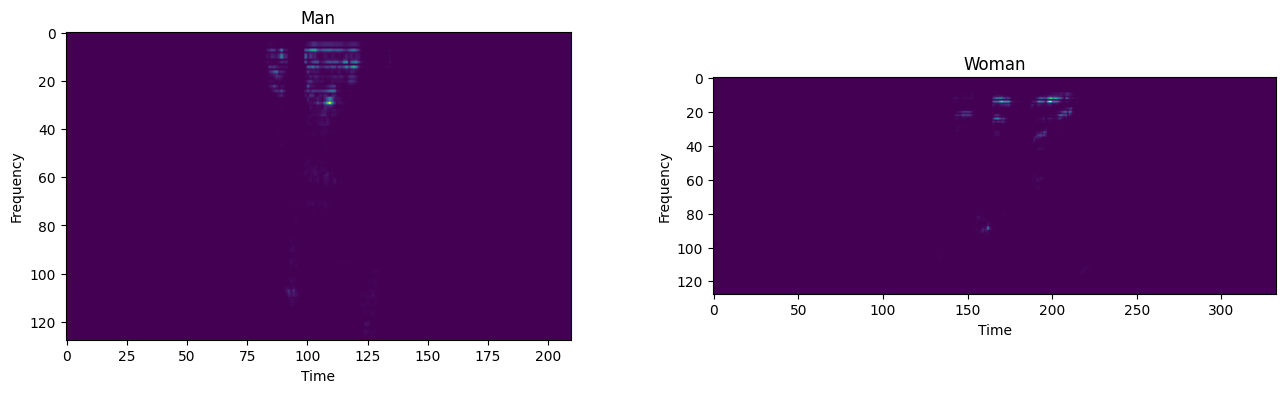

In [46]:
plt.figure(figsize=[16, 4])
plt.subplot(1, 2, 1)
plt.title("Man"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(mel1[0])

plt.subplot(1, 2, 2)
plt.title("Woman"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(mel2[0]);

## 2. Dataset


Data shuffle

In [8]:
import os
import random
from shutil import copyfile

base_dir = '/home/stud_valery/simple_audio_classification/data/'
data_dir = base_dir + 'train/'

# Set the ratio for the train-test split (e.g., 80% train, 20% test)
train_ratio = 0.8
test_ratio = 0.2

# Get a list of all the files in the directory
file_list = os.listdir(data_dir)

# Randomly shuffle the list of files
random.shuffle(file_list)

# Calculate the number of files for training and testing
num_files = len(file_list)
num_train = int(train_ratio * num_files)
num_test = num_files - num_train

# Create separate directories for train and test data
train_directory = base_dir + 'train_split/'
test_directory = base_dir + 'test_split/'

os.makedirs(train_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

# Copy files to the train directory
for file_name in file_list[:num_train]:
    source_path = os.path.join(data_dir, file_name)
    destination_path = os.path.join(train_directory, file_name)
    copyfile(source_path, destination_path)

# Copy files to the test directory
for file_name in file_list[num_train:]:
    source_path = os.path.join(data_dir, file_name)
    destination_path = os.path.join(test_directory, file_name)
    copyfile(source_path, destination_path)

In [69]:
df = pd.read_csv('/home/reznik24/Contests/targets.tsv', sep='\t', header=None, names=['filename', 'class'])

In [63]:
targets = np.array(df['Class'])
np.bincount(targets)

array([7620, 6316])

Training dataset contains 7620 males voices and 6316 females. Unbalanced, but not much, so it's not that important

## 3. Model architecture

In [4]:
import torch
params = torch.load('/home/stud_valery/simple_audio_classification/data/train_record/no_name/params/last_epoch.pt',\
                     map_location='cuda:'+str(0))
# model.load_state_dict(params)

<All keys matched successfully>

In [8]:
print(model)

Model(
  (conv_blocks): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2-6): 5 x ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (7): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 1

In [3]:
#calculating shapes
def base_formula(n_in, k, p, s):
    return int((n_in + 2*p - k)/s) + 1
def shape_after_pooling(h, w, ker_hw, p=0):
    return base_formula(h, ker_hw, p, ker_hw), base_formula(w, ker_hw, p, ker_hw)
def shape_after_conv2d(h, w, ker_hw, p=0, s=1):
    return base_formula(h, ker_hw, p, s), base_formula(w, ker_hw, p, s)

# Inference Tool

In [3]:
#initialize the model and some dataset
from MakeDataset import MakeDataset
from Model import Model
import torch
dataset = MakeDataset('', 'test', unlabeled_mode=True)

model = Model(num_classes=2, device=0).to(0)
params = torch.load('',\
                     map_location='cuda:0')
model.load_state_dict(params)
model.eval()
None

get test dataset from /home/stud_valery/simple_audio_classification/data...:   0%|          | 0/3413 [00:00<?, ?it/s]

/home/stud_valery/anaconda3/envs/torchenv/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
get test dataset from /home/stud_valery/simple_audio_classification/data...: 100%|██████████| 3413/3413 [00:08<00:00, 390.27it/s]


In [2]:
#random predict from given dataset or file
import IPython
import random
model.eval()
def predict(filename=None):
    if filename==None:
        audio, filepath = random.choice(dataset)
    else:
        filepath = filename
        audio = dataset.process_audio_file(filepath)
    with torch.no_grad():
        out = model(audio.unsqueeze(0).to(0))
    out = 'male' if out < 0.5 else 'female'
    print(out)
    return filepath
filepath = predict()
IPython.display.Audio(filepath, rate=16000)

female


In [2]:
#evaluate or get predictions on dataset
from Evaluater import Evaluater
from torch.utils.data import DataLoader
predict_dataloader = DataLoader(dataset=dataset, batch_size=60,
                              shuffle=False, num_workers=8, drop_last=False)
evaluater = Evaluater(model, predict_dataloader, device=0)
evaluater.get_predicts('./data/')
None

Calculating predictions...: 100%|██████████| 57/57 [00:07<00:00,  7.65it/s]
